<a href="https://colab.research.google.com/github/LCaravaggio/NLP/blob/main/06_clasificaci%C3%B3n/Entrenar_modelo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

import plotly.graph_objs as go
import plotly.tools as tls
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Vamos a usar datos de reviews de amazon que salen de acá: 
# https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?select=Reviews.csv

import json
from google.colab import drive

!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/kaggle.json", 'r') as f:
    api_token= json.load(f)

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d snap/amazon-fine-food-reviews


Mounted at /content/drive
 99% 240M/242M [00:01<00:00, 189MB/s]
100% 242M/242M [00:01<00:00, 137MB/s]


In [4]:
# Extraigo todos los archivos que están en el .zip que acabamos de "bajar". 

import zipfile
import os

os.listdir()

for file in os.listdir():
    if file.endswith('.zip'):
      zip_ref = zipfile.ZipFile(file, 'r')
      zip_ref.extractall()
      zip_ref.close()

In [5]:
df = pd.read_csv('/content/Reviews.csv')
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [6]:
df.shape

(568454, 10)

In [7]:
# Product Scores
fig = px.histogram(df, x="Score")
fig.update_layout(title_text='Product Score')
fig.show()

In [8]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [23]:
df.Text[220]

'I drink this tea plain (without sugar or milk), and it has a pleasant aroma.<br /><br />The price from Amazon is cheaper than my local grocery store.  One reviewer is right, I think it has some herbal smell to make up the aroma.  So the label "Imperial Blend" kind of implied the herb.<br /><br />I am not exactly a black tea drinker, so this tea is a surprise, and affordable too.  I usually prefer White Chinese tea, like White Peony, but it is more expensive, and requires lower temperature water.  But this is black tea, and this aroma kind of remind me the \'softness\' of white tea.'

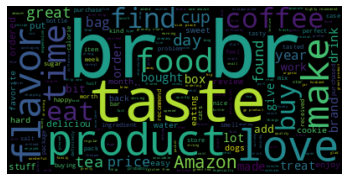

In [10]:
from nltk.corpus import stopwords
from wordcloud import WordCloud

stopwords = set(stopwords.words())

# Agergo la palabra br pq aparece muchas veces por el corrimiento de carril 
stopwords.update(["br"])

textt = " ".join(review for review in df.Text)
wordcloud = WordCloud(stopwords=stopwords).generate(textt)


plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [24]:
df = df[df['Score'] != 3]
df['sentiment'] = df['Score'].apply(lambda rating : +1 if rating > 3 else -1)

In [25]:
# Genero dos datasets distintos, uno con reviews "positivas" y otro con reviews "negativas"
positive = df[df['sentiment'] == 1]
negative = df[df['sentiment'] == -1]

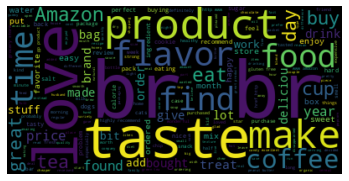

In [26]:
pos = " ".join(review for review in positive.Text)
wordcloud2 = WordCloud(stopwords=stopwords).generate(pos)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis("off")
plt.show()

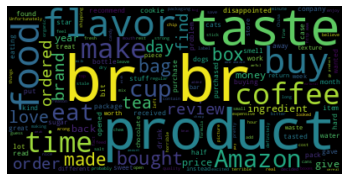

In [27]:
neg = " ".join(review for review in negative.Text)
wordcloud3 = WordCloud(stopwords=stopwords).generate(neg)
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis("off")
plt.show()

In [28]:
def remove_punctuation(text):
    final = "".join(u for u in text if u not in ("?", ".", ";", ":",  "!",'"'))
    return final
df['Text'] = df['Text'].apply(remove_punctuation)
df = df.dropna(subset=['Summary'])
df['Summary'] = df['Summary'].apply(remove_punctuation)

In [29]:
dfNew = df[['Summary','sentiment']]
dfNew.head()

,Summary,sentiment
0,Good Quality Dog Food,1
1,Not as Advertised,-1
2,Delight says it all,1
3,Cough Medicine,-1
4,Great taffy,1


In [32]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(df, test_size=0.2)

In [33]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
train_matrix = vectorizer.fit_transform(train['Summary'])
test_matrix = vectorizer.transform(test['Summary'])

In [34]:
print(train_matrix[0])

  (0, 28200)	1
  (0, 30574)	1
  (0, 12257)	1
  (0, 14301)	1
  (0, 17983)	1


In [35]:
len(vectorizer.get_feature_names_out())

31794

In [36]:
np.where(vectorizer.get_feature_names_out() == 'dog')[0][0]

8639

In [38]:
vectorizer.get_feature_names_out()[8639]

'dog'

# Naive Bayes

In [39]:
from sklearn.naive_bayes import MultinomialNB

In [40]:
clf=MultinomialNB()

In [41]:
X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']

In [42]:
clf.fit(X_train,y_train)

MultinomialNB()

In [44]:
predictions = clf.predict(X_test)

In [45]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[10892,  3516],
       [ 5454, 85296]])

In [46]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -1       0.67      0.76      0.71     14408
           1       0.96      0.94      0.95     90750

    accuracy                           0.91    105158
   macro avg       0.81      0.85      0.83    105158
weighted avg       0.92      0.91      0.92    105158



# Logistic Regression

In [47]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(penalty='none')

In [48]:
X_train = train_matrix
X_test = test_matrix
y_train = train['sentiment']
y_test = test['sentiment']

In [49]:
lr.fit(X_train,y_train)

LogisticRegression(penalty='none')

In [50]:
predictions = lr.predict(X_test)

In [51]:
# find accuracy, precision, recall:
from sklearn.metrics import confusion_matrix,classification_report
new = np.asarray(y_test)
confusion_matrix(predictions,y_test)

array([[11179,  2426],
       [ 5167, 86386]])

In [52]:
print(classification_report(predictions,y_test))

              precision    recall  f1-score   support

          -1       0.68      0.82      0.75     13605
           1       0.97      0.94      0.96     91553

    accuracy                           0.93    105158
   macro avg       0.83      0.88      0.85    105158
weighted avg       0.94      0.93      0.93    105158



In [53]:
print(X_test[0])

  (0, 11193)	1
  (0, 15604)	1
  (0, 18416)	1
  (0, 18723)	1
  (0, 19141)	1
  (0, 28971)	1
  (0, 29079)	1


In [54]:
lr.predict(X_test[0])

array([1])

In [55]:
X_test[0]

<1x31794 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [67]:
np.where(vectorizer.get_feature_names_out() == 'good')[0][0]

12265

In [69]:
np.where(vectorizer.get_feature_names_out() == 'tasty')[0][0]

27747

In [70]:
from scipy.sparse import csr_matrix
import numpy as np
data = np.array([1,1])
indices = np.array([12265, 27747])
indptr  = np.array([0,2])
prueba=csr_matrix((data, indices, indptr), shape=(1,31794))

In [71]:
prueba

<1x31794 sparse matrix of type '<class 'numpy.int64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [72]:
print(prueba)

  (0, 12265)	1
  (0, 27747)	1


In [73]:
lr.predict(prueba)

array([1])

In [74]:
np.where(vectorizer.get_feature_names_out() == 'horrible')[0][0]

13825

In [66]:
np.where(vectorizer.get_feature_names_out() == 'bad')[0][0]

2500

In [75]:
data = np.array([1,1])
indices = np.array([13825, 2500])
indptr  = np.array([0,2])
prueba=csr_matrix((data, indices, indptr), shape=(1,31794))

In [76]:
lr.predict(prueba)

array([-1])